# **[ HW6 Bonus ]** Generative Adversarial Networks (GANs)


Many of the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence translation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). 

**Autoencoder**: More recently, we've started covering various autoencoders, which are great for **generative** (or *auto-regressive*) problem settings. By applying a reconstruction loss, we are able to generate decent reconstructions.

**Problem With Autoencoders**: When implementing autoencoders for generative tasks, we make two assumptions: 

- Minimizing reconstruction loss can give us a good generation.
- Minimizing distribution loss can give us nice latent properties. 

Sometimes, however, we don't really have a good reconstruction formulation. For example, we can train up an autoencoder to reconstruct cats and dogs, but maybe enforcing reconstruction via a color-channel loss doesn't actually encourage the network to learn much about the actual meaningful properties of our domain. So... then maybe we don't have a good loss function for this...

## What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called **GANs** (*Generative Adversarial Networks*). 

In a GAN, our objective it to learn a generative model $G$ that can generate good synthetic data entries $X_{pred}$ similar to a real data $X_{true}$. 

To do this, we need two models: 
- **Discriminator**: A traditional classification network that maps $X$-likes to a probability.
- **Generator**: A decoder-like network that samples up from a condensed space to an $X$-like output.

The training objectives are: 
- Train generator $G$ to output synthetic $X_{pred}$ when given a random input entry.
- Train discriminator $D$ to predict whether an inputted $X$-like is from $X_{true}$ or $X_{pred}$.

This can be set up in an adversarial way by training the generator to fool the discriminator and vice versa. 

#### **In this assignment, we will alternate the following updates:**
1. Update $G$ to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update $D$ to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

For more information, refer to the GAN slides and the GAN Loss section.

### Further Exploration?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling, check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is using Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

### Details

For this component, we'll just be implementing the simplest kind of GAN, but there are several variations that can yield better results.

GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment not take forever, we will be working on a subset of the MNIST dataset, which contains 60,000 training and 10,000 test images.

Example GAN outputs (yours should look like the ones on the left):

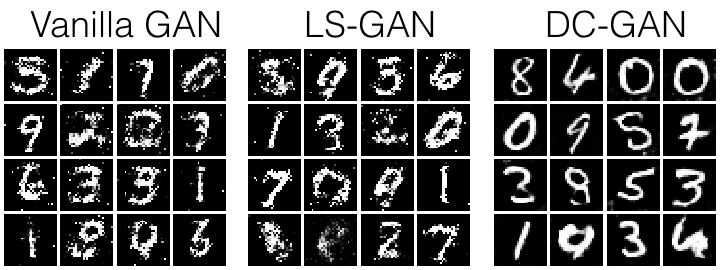

## Setup and Data
* Make sure to enable a GPU by navigating to `Edit -> Notebook Settings` and selecting `Hardware Accelerator: GPU`


In [ ]:
import tensorflow as tf
import numpy as np
import IPython.display

- We'll be taking advantage of old-reliable MNIST. Nothing too crazy yet...

In [ ]:
if "X0" not in globals():
    (X0, L0), (_, _) = tf.keras.datasets.mnist.load_data()
    X0 = tf.cast(X0, tf.float32) / 255.0
    X0 = tf.expand_dims(X0, -1)

## Setting up Our GAN

Recall what we said earlier: A GAN is structured with two components: 

- **Discriminator**: Predicts if an input is synthetic or real.
- **Generator**: Generates a synethetic entry when given a input. 

As such, our unified architecture will need both of these. It also needs to generate random input samples for our generator, which we will refer to as a randomly-generated $z$ tensor. We can pull these from a normal distribution, though some formulations may take advantage of other sampling techniques. 

- **$z$ Sampler:** Generates a random input to use for Generator.

To help administrate all of this, we will define the `GAN_Core` class. This class takes in a discriminator model, generator model, and sampling specification as arguments and organized all of them so that we can use them as necessary. We will later extend this class to allow us to train the GAN model in a similar fashion as your previous implementations.

### **Linking Up The Two Models**

You may recall that earlier we combined multiple `tf.keras.Sequential` models together and trained them all in an end-to-end fashion. This was because we connected our models in the call specification, thereby linking two `tf.Variable` wrappers. 

For the GAN model, we want to train them on a per-epoch basis, but will need to update the generator and discriminator at different times: **Update one first, and then the other.** If we trained both of them at the same time, the joint procedure would combine into a single loss-function and the two models will likely lock up as their conflicting loss terms cancel out.   

However, we do still want our core model to administrate the two models and do joint operations (outside of training) to simplify our lives. To do this, you will need to connect all of the components together in the GAN `call` function (even if you never end up using this function).

----
**TODO:** As such, implement your call function to connect the sampler (technically optional), generator, and discriminator. While you're at it, go ahead and print out the shapes of all of these. You'll never use this call function yourself, but Tensorflow may use it sometimes so... might as well see when, and also get a reminder about what your data looks like!

**Hint:**
- Consider using `tf.shape()[0]` to get the batch dimension. Have the batch dimension persist through the call function. 
- Use the next cell to test out your core

In [ ]:
def log_if_unsafe(func, msg="unsafe operation"):
    '''Function wrapper. Warns if function is not called with safe param'''
    def output_fn(*args, safe=False, **kwargs):
        if not safe: print(f"Warning: {msg}")
        return func(*args, **kwargs)
    return output_fn


class GAN_Core(tf.keras.Model):

    '''
    Core class to administrate both the generator and discriminator
    '''

    def __init__(self, dis_model, gen_model, z_dims, z_sampler=tf.random.normal, **kwargs):
        '''
        self.gen_model = generator model;           z_like -> x_like
        self.dis_model = discriminator model;       x_like -> probability
        self.z_sampler = sampling strategy for z;   z_dims -> z
        self.z_dims    = dimensionality of generator input
        '''
        super().__init__(**kwargs)
        self.z_dims = z_dims
        self.z_sampler = log_if_unsafe(z_sampler, "z_sampler(shape, ...) is an internal function. Consider using sample_z(n)")
        self.gen_model = gen_model
        self.dis_model = dis_model
        
    '''
    New calling API for the model
    '''

    def sample_z(self, num_samples, **kwargs):
        '''generates an z based on the z sampler'''
        return self.z_sampler([num_samples, *self.z_dims[1:]], safe=True)
    
    def discriminate(self, inputs, **kwargs):
        '''predict whether input input is a real entry from the true dataset'''
        return self.dis_model(inputs, **kwargs)

    def generate(self, z, **kwargs):
        '''generates an output based on a specific z realization'''
        return self.gen_model(z, **kwargs)

    '''
    keras.Model will handle all components defined in its end-to-end architecture.  
    As such, we can link the generator and discriminator within the GAN by:
     - Chaining the generator and discriminator together in the call function
     - Building the GAN in the way that facilitates this call function. 
    '''
    def call(self, inputs, **kwargs):
        ## TODO
        z_samp = None       ## Generate a z sample
        g_samp = None       ## Generate an x-like image
        d_samp = None       ## Predict whether x-like is real
        print(f'Z( ) Shape = {z_samp.shape}')
        print(f'G(z) Shape = {g_samp.shape}')
        print(f'D(x) Shape = {d_samp.shape}\n')
        ## And similar...
        return d_samp

    def build(self, input_shape, **kwargs):
        super().build(input_shape=self.z_dims, **kwargs)

### **Creating A Simple GAN**
Next, we'll create a very simple GAN architecture. We still can't train it yet, but we can still put in the parameters and look at it!

* For the sake of simplicity, please use the simpelest possible discriminator and generator architectures for this portion of the assignment (a single dense layer)

* HINT: Think about whether we need to reshape the output (or input) of the two models generator!

In [ ]:
## TODO: Make a simplest-possible discriminator sub-model for MNIST (w/ 1 dense)
def basic_dis_model(name="dis_model"):
    return None

## TODO: Make a simplest-possible generator sub-model for MNIST (w/ 1 dense)
def basic_gen_model(name="gen_model"):
    return None

gan_proto = GAN_Core(
    dis_model = basic_dis_model(), 
    gen_model = basic_gen_model(), 
    z_dims = (None, 96),    ## Generator input shape
    name="gan_core"
)

gan_proto.build(input_shape = X0.shape)
gan_proto.summary()

print(len([55]))
# gan_proto.gen_model.summary()
# gan_proto.dis_model.summary()

**Expected Values:**
```
Z( ) Shape = (None, 96)
G(x) Shape = (None, 28, 28, 1)
D(x) Shape = (None, 1)
gan_core Param #: 76,833
```

## GAN Loss

The GAN loss may seem daunting, but it's actually quite simple.
We define $X_{fake}$ to be equal to the output from the generator $G(z)$.
We also define the output of the discriminator to be equal to 1 when it
classifies the input as real; and equal to 0, when it classifies it as fake.

----

- The generator is trained to output synthetic data that makes the discriminator misclassify:
  - It wants $D(X_{fake})$ to be close to 1 ...
    - ... so minimize negative log-loss (i.e. the discriminator classifying fake generator data as real)
    
$$\ell_G  =  -\mathbb{E}\left[\log D(X_{fake})\right]$$

----

$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

----

- The discriminator is trained to predict real as real and fake as fake.
  - Want $D(X_{true})$ to be close to 1 ...
    - ... so minimize negative log loss function (NLL) term $-\mathbb{E}\left[\log D(X_{true})\right]$

    $$= -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right]$$
    
  - Want $D(X_{fake})$ to be close to 0 ...
    - ... so minimize NLL term $-\mathbb{E}\left[\log \left(1- D(X_{fake})\right)\right]$
    
    $$= - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

----

$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

----

Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

Soo.... go ahead and implement them! Assume `d_real` is the decision on the real input entries and `d_fake` is the decision on the synthetic input entries. 

While you're at it, also implement the **binary accuracy** metrics for giving us a more human-interpretable generator and discriminator models are comparing!

**HINTS**: 

- You can use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate ideal labels. 
- We will be providing the `bce_func` and `acc_func` aliases. Recall that: $$L_{BCE}(\hat y, y) = -\frac{1}{n}\sum_{n}\bigg(y \log(\hat y) + y^c\log(\hat y^c)\bigg) \text { for } x^c = 1-x$$

- If the relationship between the loss functions and the accuracy functions isn't obvious, I will give you the hint that the contents of `g_loss` and `g_acc` should differ by exactly three letters...
- For good practice, you might want to reduce the losses down to their means (though keras actually won't care in this scenario).

In [ ]:
"""
Compute the GAN loss.
    
Inputs:
- logits_real: Tensor, shape [batch_size, 1], output of discriminator for each real image
- logits_fake: Tensor, shape[batch_size, 1], output of discriminator for each fake image
"""

bce_func = tf.keras.backend.binary_crossentropy  ## optional
acc_func = tf.keras.metrics.binary_accuracy      ## optional

# TODO: fill in loss functions!
def d_loss(d_fake:tf.Tensor, d_real:tf.Tensor)  -> tf.Tensor:
    return 0

def g_loss(d_fake:tf.Tensor, d_real:tf.Tensor) -> tf.Tensor:
    return 0

# TODO: fill in accuracy functions!
def d_acc_fake(d_fake:tf.Tensor, d_real:tf.Tensor)  -> tf.Tensor:
    return 0

def d_acc_real(d_fake:tf.Tensor, d_real:tf.Tensor)  -> tf.Tensor:
    return 0

def g_acc(d_fake:tf.Tensor, d_real:tf.Tensor) -> tf.Tensor:
    return 0

################################################################################

def test_metric(loss_fn, fake, real, expected):
    value = loss_fn(tf.constant(fake), tf.constant(real)).numpy()
    print(f'{loss_fn.__name__:11} with ' + 
        f'fake {str(fake):15} and real {str(real):15} = ' + 
        f'{value:6.3f}\t[{expected:6.3f}]')

test_metric(d_loss,     [0., 0., 0.], [1., 1., 1.], -0.0)
test_metric(d_loss,     [0., 0., 0.], [0., 0., 0.], 15.425)
test_metric(d_loss,     [1., 1., 1.], [1., 1., 1.], 15.333)
test_metric(d_loss,     [1., 1., 1.], [0., 0., 0.], 30.758)
print()
test_metric(g_loss,     [1., 1., 1.], [],           -0.0)
test_metric(g_loss,     [0., 0., 0.], [],           15.425)
print()
test_metric(g_acc,      [.1, .9, .9], [],           0.667)
test_metric(d_acc_fake, [.1, .9, .9], [],           0.333)
test_metric(d_acc_real, [], [.1, .9, .9],           0.667)

**Expected:**
```
d_loss      with fake [0.0, 0.0, 0.0] and real [1.0, 1.0, 1.0] = -0.000	[-0.000]
d_loss      with fake [0.0, 0.0, 0.0] and real [0.0, 0.0, 0.0] = 15.425	[15.425]
d_loss      with fake [1.0, 1.0, 1.0] and real [1.0, 1.0, 1.0] = 15.333	[15.333]
d_loss      with fake [1.0, 1.0, 1.0] and real [0.0, 0.0, 0.0] = 30.758	[30.758]

g_loss      with fake [1.0, 1.0, 1.0] and real []              = -0.000	[-0.000]
g_loss      with fake [0.0, 0.0, 0.0] and real []              = 15.425	[15.425]

g_acc       with fake [0.1, 0.9, 0.9] and real []              =  0.667	[ 0.667]
d_acc_fake  with fake [0.1, 0.9, 0.9] and real []              =  0.333	[ 0.333]
d_acc_real  with fake []              and real [0.1, 0.9, 0.9] =  0.667	[ 0.667]
```

## Epoch Visualization Callback.

In [ ]:
#@markdown You don't really have to look at it, so just run the block with the play button.

#@markdown * If you open up the code, double-click the right side of the cell to hide it again 
import matplotlib.pyplot as plt
from PIL import Image
import io

class EpochVisualizer(tf.keras.callbacks.Callback):
    def __init__(self, model, sample_inputs, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.sample_inputs = sample_inputs
        self.imgs = [] 

    def on_epoch_end(self, epoch, logs=None):
        x_real, z_samp = self.sample_inputs
        x_fake = self.model.gen_model(z_samp)
        d_real = tf.nn.sigmoid(self.model.dis_model(x_real))
        d_fake = tf.nn.sigmoid(self.model.dis_model(x_fake))
        outputs = tf.concat([x_real, x_fake], axis=0)
        labels  = [f"D(true x) = {np.round(100 * d, 0)}%" for d in d_real] 
        labels += [f"D(fake x) = {np.round(100 * d, 0)}%" for d in d_fake]

        self.add_to_imgs(
            outputs = outputs,
            labels = labels,
            epoch = epoch
        )

    def add_to_imgs(self, outputs, labels, epoch, nrows=1, ncols=8, figsize=(16, 5)):
        '''
        Plot the image samples in outputs in a pyplot figure and add the image 
        to the 'imgs' list. Used to later generate a gif. 
        '''
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        if nrows == 1: axs = np.array([axs])
        fig.suptitle(f'Epoch {epoch+1}')
        axs[0][0].set_title(f'Epoch {epoch+1}')
        for i, ax in enumerate(axs.reshape(-1)):
            out_numpy = np.squeeze(outputs[i].numpy(), -1)
            ax.imshow(out_numpy, cmap='gray')
            ax.set_title(labels[i])
        self.imgs += [self.fig2img(fig)]
        plt.close(fig)

    @staticmethod
    def fig2img(fig):
        """
        Convert a Matplotlib figure to a PIL Image and return it
        https://stackoverflow.com/a/61754995/5003309
        """
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        return Image.open(buf)
    
    def save_gif(self, filename='mnist_recon', loop=0, duration=500):
        imgs = self.imgs
        self.imgs[0].save(
            filename+'.gif', save_all=True, append_images=self.imgs[1:], 
            loop=loop, duration=duration)

## The Generator and Discriminator Architectures
Now that we've created our loss functions, we'll create new discriminator and generator architectures that might actually work... sorta!

So as we said, GANs are infamous for how finicky they are to train *at all*. Moreover, training them *quickly* is another problem altogether. 

I spent a **very long time (many hours)** trying to come up with a better architecture because I think the below architecture ***shouldn't be good***, but a previous TA probably spent a long time arriving to it and ***for some reason*** it manages to at least show signs of convergence pretty quickly on a normal GAN implementation. 

This architecture doesn't really abide by the tricks people talk about for image-based GANs, but the rate of convergence for both the discriminator and generator will about even out when trained with the hyperparameters in the later cells. 

**For the discriminator:** 
 - Flatten the input image and pass it through a 256->256->1 dense layer sequence. 
 - Make the intermediate layers LeakyReLU-0.01 activated and activate the output with a sigmoid.

**For the generator:** 
 - Flatten the input z-sample (just in case) and pass it through a 1000->1000->784 dense layer sequence. 
 - Make the intermediate layers LeakyReLU-0.01 activated and activate the output with a tanh (i.e. to [-1, 1] space). 
 - Reshape the output to the same shape as the MNIST images.

**NOTES**: 
- ***Why tanh for the generator?*** 

Because the alternative, sigmoid activating function, doesn't lead to convergence. This is also a common trick for helping with GAN training convergence. Scaling the [-1, 1] output to [0, 1] will also cause this system to fail, but scaling it to [-0.5, 1.5] (i.e. by using the `Rescaling` layer with scale 1 and a slight offset) does improve the training routine (probably because the outputs are kept in the middle 50% of the output space and the model doesn't have to optimize to output along the edge of the tanh range).



In [ ]:
leaky_relu = tf.keras.layers.LeakyReLU(0.01)

def get_dis_model(name="dis_model"):
    return tf.keras.Sequential([
        ## TODO: Implement per instructions
    ], name=name)

def get_gen_model(name="gen_model"):
    return tf.keras.Sequential([
        ## TODO: Implement per instructions
    ], name=name)

gan_model = GAN_Core(    
    dis_model = get_dis_model(), 
    gen_model = get_gen_model(), 
    z_dims = (None, 96),
    name="gan"
)

gan_model.build(input_shape = X0.shape)
# gan_model.summary()
gan_model.gen_model.summary()
gan_model.dis_model.summary()

## Putting It All Together

Well, we have our discriminator, our generator, and our loss functions. We also have an example of how they "could" be combined together. Now, it's time to actually assemble everything!

And welcome to the hard part! We said earlier that we wanted to use the `GAN_Core` model to get all of the GAN sub-components together and join them up for some convenient functionality (i.e. to give a unified training API). But now we actually have to train the generator and discriminator models... separately.

We mentioned earlier that training them at the same time wouldn't work since the loss terms would just conflict. So, we'll have to train one, then the other, then repeat.

To make our GAN flexible and easy to work with, we will be introducing some custom arguments. 

- `fit` will now also accept `dis_steps` and `gen_steps` to show how many times *in a row* we will train the discriminator and generator. 
- `compile` will now take dictionaries of optimizers, loss functions, and metrics, and will store them in the GAN object to be used later (and will also compile the model).

These have already been implemented for you. Also, since you're extending from `GAN_Core`, you also have access to all of its useful methods, which are listed out for convenience. 

**TODO**:

Implement the `test_step`, then `train_step`, methods to specify how you want to train and test your optimization routine. 
- `train_step` has been implemented in previous labs and is called as part of the `fit` routine to process every batch of data. A basic example has been included for you. The metric cracking is already implemented. Make sure to use the `dis_steps` and `gen_steps` variables. 
- `test_step` can be called when you do non-training routines (i.e. if you were to specify `validation_data` in your `fit` call).

**NOTES**:
- Remember that the outputs of `train_step` should be end-statistics (both loss and metrics), so they will need to be computed one last time after the tape-enabled training routine has finished. 
- The cell block after this visualized the callback images as a GIF. This should be familiar.

In [ ]:
class GAN(GAN_Core):

    '''
    self.gen_model = generator model;           z_like -> x_like
    self.dis_model = discriminator model;       x_like -> probability
    self.z_sampler = sampling strategy for z;   z_dims -> z
    self.z_dims    = dimensionality of generator input
    self.sample_z(n)      = sample n sampled z realizations
    self.generate(z)      = generate x-likes from provided z
    self.discriminate(x)  = predict whether x-like is real or generated
    '''

    def compile(self, optimizers, losses, accuracies, **kwargs):
        super().compile(
            loss        = losses.values(),
            optimizer   = optimizers.values(),
            metrics     = accuracies.values(),
            **kwargs
        )
        self.loss_funcs = losses
        self.optimizers = optimizers
        self.acc_funcs  = accuracies


    def fit(self, *args, dis_steps=1, gen_steps=1, **kwargs):
        self.gen_steps = gen_steps
        self.dis_steps = dis_steps
        super().fit(*args, **kwargs)


    def test_step(self, data):
        x_real, l_real = data
        batch_size = tf.shape(x_real)[0]

        ## TODO: Generate the inputs for the loss functions: 
        ## - x_real: Real Images from dataset
        ## - d_real: The discriminator's prediction of the reals
        ## - x_fake: Images generated by generator
        ## - d_fake: The discriminator's prediction of the fakes
        #### Student Implementation Starts Here                                 ####

        #### Student Implementation Ends Here                                   ####

        metrics = dict()
        all_funcs = {**self.loss_funcs, **self.acc_funcs}
        for key, func in all_funcs.items():
            metrics[key] = func(d_fake, d_real)  ## Interesting variables...

        return metrics

    
    def train_step(self, data):
        x_real, l_real = data
        batch_size = tf.shape(x_real)[0]

        #### Student Implementation Starts Here                                 ####
          
        ## TODO: Train the discriminator for `self.dis_steps` steps
        loss_fn   = self.loss_funcs['d_loss'] ## HINT
        optimizer = self.optimizers['d_opt']  ## HINT

        for _ in range(self.dis_steps):
            ## Optimize the appropriate model

        ## TODO: Train the generator for `self.gen_steps` steps

        for _ in range(self.gen_steps):
            ## Optimize the appropriate model

        ## TODO: Compute final states for metric computation (if necessary)

        #### Student Implementation Ends Here                                   ####

        metrics = dict()
        all_funcs = {**self.loss_funcs, **self.acc_funcs}
        for key, func in all_funcs.items():
            metrics[key] = func(d_fake, d_real)  ## Interesting variables...

        return metrics


    ## OLD BASIC EXAMPLE FROM LAB 3 AND 4
    ## def train_step(self, data):
    ##     '''
    ##     Optional Train_Step Specification; This happens for every training batch
    ##     https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    ##     '''
    ##     x, y = data   ## train_step generally accepts a batch input/label tuple
    ##     with tf.GradientTape() as tape:
    ##         y_pred = self(x, training=True)  # Forward pass
    ##         loss = self.compiled_loss(y, y_pred)
    ##
    ##     train_vars = self.trainable_variables
    ##     gradients = tape.gradient(loss, train_vars)
    ##     self.optimizer.apply_gradients(zip(gradients, train_vars))
    ##     # ...

gan_model = GAN(   
    dis_model = get_dis_model(), 
    gen_model = get_gen_model(), 
    z_dims    = (None, 96),
    name      = "gan"
)

gan_model.compile(
    optimizers = {
        'd_opt' : tf.keras.optimizers.Adam(1e-3, beta_1=0.5), 
        'g_opt' : tf.keras.optimizers.Adam(1e-3, beta_1=0.5), 
    },
    losses = {
        'd_loss' : d_loss,
        'g_loss' : g_loss,
    },
    accuracies = {
        'd_acc_real' : d_acc_real,
        'd_acc_fake' : d_acc_fake,
        'g_acc'      : g_acc,
    }
)

train_num = 50000       ## Feel free to bump this up to 50000 when your architecture is done
true_sample = X0[train_num-2:train_num+2]                       ## 4 real images
fake_sample = gan_model.z_sampler((4, *gan_model.z_dims[1:]))   ## 4 fake images
# fake_sample = gan_model.sample_z(4)                           ## 4 fake images
viz_callback = EpochVisualizer(gan_model, [true_sample, fake_sample])

gan_model.fit(
    X0[:train_num], L0[:train_num], 
    dis_steps  = 5, 
    gen_steps  = 5, 
    epochs     = 10, ## Feel free to bump this up to 20 when your architecture is done
    batch_size = 50,
    callbacks  = [viz_callback]
)

In [ ]:
viz_callback.save_gif('generation')
IPython.display.Image(open('generation.gif','rb').read())

### **[ FOR CREDIT | BONUS ]**
- For 2470 students, the above will give you half of the bonus points. The other half can be obtained by trying out the WGAN-GP model below. 

- Make sure that your gif and all other cell outputs are present in your notebook!

- Discuss a bit about the pros and cons of using a GAN in this context. 

# **BONUS**: WGANs with Gradient Penalty 

Unless you are really well-informed or want to set up a controlled experiment for research purposes (i.e. baseline or fundamentals argument), you probably shouldn't implement a basic GAN for almost any reason. A step up from the basic GAN is a **Wasserstein GAN**. This variation has good theorhetical properties compared to a normal GAN, and the core of the difference is: 

- Uses the [Wasserstein metric](https://en.wikipedia.org/wiki/Wasserstein_metric) instead of cross-entropy, which computes the amount of energy required to transform a distribution into another. Many people use the "moving earth" analogy since it accumulates an $amount \times distance$ relationship, so it is colloquially called "Earth-Mover's Distance"
  - EMD between two probability vectors $P_0$ and $P_1$ = $mean(P_0 \times P_1)$ for element-wise product. Since we're trying to transform the $D$'s classification of $G$'s output to the distribution of ones, we want to minimize $EMD$ between $D(G(z))$ and the distribution of ones... so $mean(D(G(z)))$... and similarly for the other objectives. 
- Uses a "critic" instead of a "generator" (a consequence of using EMD).
- Tries to enforce a [Lipzchits constraint](https://en.wikipedia.org/wiki/Lipschitz_continuity) to help convergence by restricting the gradients to a reasonable range. 
  - Previous implementations used gradient clipping, which was problematic since it added technical discontinuity into the optimization despite still being roughly differentiable as far as the optimization process is concerned.
  - Modern implementations use gradient penalty (WGAN-GP) to restrict the gradient shift as part of the optimization loop.

#### Keras provides a basic implementation of WGAN-GP... so why don't you try it out?
### https://keras.io/examples/generative/wgan_gp/

They also: 
- Use a more recommended architecture for medium-term training, which should lead to better results in addition to the inherent benefits of WGAN.

- Use Fashion-MNIST, which is a neat additional dataset to play around with!

----

Now as a bonus, I'd recommend seeing if you could take our code and their code and making your own implementation that leverages a bit of both versions! It would be nice if you could just have a WGAN implementation that you're familiar with so that you can just pull it out of your pocket when a problem arises!

In [ ]:
#@title WGAN_Core Implementation (just run)
#@markdown - `criticize(x_like)` alias for `discriminate(x_like)`
#@markdown - `crt_model` alias for `dis_model`
#@markdown - `compile()` and `fit()` already implemented 
#@markdown - `fit` now takes in gradient penalty (`gp_weight`) term to scale contribution of raw gradient loss term
class WGAN_Core(GAN_Core):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.criticize = self.discriminate
        self.crt_model = self.dis_model

    def compile(self, optimizers, losses, accuracies, **kwargs):
        super().compile(
            loss        = losses.values(),
            optimizer   = optimizers.values(),
            metrics     = accuracies.values(),
            **kwargs
        )
        self.loss_funcs = losses
        self.optimizers = optimizers
        self.acc_funcs  = accuracies


    def fit(self, *args, gp_weight=10, d_steps=1, g_steps=1, **kwargs):
        self.g_steps = g_steps
        self.d_steps = d_steps
        self.gp_weight = gp_weight                ## gradient penalty weight
        super().fit(*args, **kwargs)

### TODO: Create a WGAN implementation that:
- Inherits from `WGAN_Core`,
- Takes inspiration from the tutorial linked above.

In [ ]:
from tensorflow.keras import layers

IMG_SHAPE = (28, 28, 1)
noise_dim = (96)

def upsample_block(
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    return tf.keras.Sequential(
        [
            layers.UpSampling2D(up_size),
            layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)
        ] +\
        [layers.BatchNormalization()] * bool(use_bn)      +\
        [activation]                  * bool(activation)  +\
        [layers.Dropout(drop_value)]  * bool(use_dropout)
    )


def wg_model():
    ub_kwargs = {
        "strides"  : (1, 1),
        "use_bias" : False,
        "use_bn"   : True,
        "padding"  : "same",
        "use_dropout" : False
    }
    return tf.keras.Sequential([
        layers.Dense(4 * 4 * 256, use_bias=False),
        layers.BatchNormalization(),
        layers.Reshape((4, 4, 256)),
        upsample_block(128, layers.LeakyReLU(0.2), **ub_kwargs),
        upsample_block( 64, layers.LeakyReLU(0.2), **ub_kwargs),
        upsample_block(  1, layers.Activation("tanh"), **ub_kwargs),
        layers.Cropping2D((2, 2))
    ], name="w_gen_model")

def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def wc_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = tf.keras.models.Model(img_input, x, name="discriminator")
    return d_model

In [ ]:
def wc_loss(d_fake, d_real):
    ## TODO

def wg_loss(d_fake, d_real):
    ## TODO

class WGAN(WGAN_Core):

    def gradient_penalty(self, batch_size, fake_images, real_images):
        # TODO: Compute Gradient Penalty
        return 0
    
    def test_step(self, data): 
        x_real, l_real = data
        batch_size = tf.shape(x_real)[0]
        z_samp = self.sample_z(batch_size)
        x_fake = self.generate(z_samp)
        d_fake = self.criticize(x_fake)
        d_real = self.criticize(x_real)

        all_funcs = {**self.loss_funcs, **self.acc_funcs}
        return { key : fun(d_fake, d_real) for key, fun in all_funcs.items() }
    
    def train_step(self, data):
        x_real, l_real = data
        batch_size = tf.shape(x_real)[0]

        ## TODO: Sample z realization to maintain some batch-level consistency

        ## TODO: Train the discriminator

        ## TODO: Train the generator

        ## TODO: Compute final states for metric computation (if necessary)

        ########################################################################

        all_funcs = {**self.loss_funcs, **self.acc_funcs}
        return { key : fun(d_fake, d_real) for key, fun in all_funcs.items() }

In [ ]:
## Potential boilerplate to call your model. Feel free to change. 

wgan_model = WGAN(   
    dis_model = wc_model(), 
    gen_model = wg_model(), 
    z_dims    = (None, 96),
    name      = "wgan"
)

wgan_model.compile(
    optimizers = {
        # 'd_opt' : tf.keras.optimizers.Adam(1e-3, beta_1=0.5), 
        # 'g_opt' : tf.keras.optimizers.Adam(1e-3, beta_1=0.5), 
        'd_opt' : tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5, beta_2=0.9), 
        'g_opt' : tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5, beta_2=0.9),
    },
    losses = {
        'd_loss' : wc_loss,     #####
        'g_loss' : wg_loss,     #####
    },
    accuracies = {
        'd_acc_real' : d_acc_real,
        'd_acc_fake' : d_acc_fake,
        'g_acc'      : g_acc,
    }
)

train_num = 10000       ## Feel free to bump this up to 50000 when your architecture is done
true_sample = X0[train_num-2:train_num+2]       ## 4 real images
fake_sample = wgan_model.sample_z(4)             ## 4 z realizations
viz_callback = EpochVisualizer(gan_model, [true_sample, fake_sample])

wgan_model.fit(
    X0[:train_num], L0[:train_num], 
    gp_weight  = 10,    ##### WGAN_Core expects this. Renamed from gp
    d_steps    = 5, 
    g_steps    = 5, 
    epochs     = 10,    ## Feel free to bump this up to 20 when your architecture is done
    batch_size = 50,
    callbacks  = [viz_callback]
)

In [ ]:
## To get credit for this, make sure to generate this!
viz_callback.save_gif('generation_wloss')
IPython.display.Image(open('generation_wloss.gif','rb').read())